In [1]:
import sys
sys.path.insert(1, './env')
sys.path.insert(1, './agents')

import gym
import pylab
import random
import aa_gun
import strategy_imitation, sarsa
import numpy as np
from collections import deque
import keras
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot as plt

from tensorflow.keras.applications import mobilenet_v2,resnet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

EPISODES = 30000
#pip install git+git://github.com/jaredwinick/img2vec-keras.git

Using TensorFlow backend.
/home/sd/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sd/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sd/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sd/anaconda3/lib/python3.7/site-packages/tensorflow/python/fra

In [2]:
_IMAGE_NET_TARGET_SIZE = (224, 224)
_EMBEDDING_SIZE = 1280

class Img2Vec(object):
    def __init__(self):
        model = mobilenet_v2.MobileNetV2(weights='imagenet')
        if 0:
            for layer in model.layers:
                print(layer.name)
        layer_name = model.layers[-2].name
        self.intermediate_layer_model = Model(inputs=model.input, 
                                              outputs=model.get_layer(layer_name).output)

    def get_vec(self, image_source, is_file=False,resize_type='crop'):
        """ Gets a vector embedding from an image.
        :param image_path: path to image on filesystem
        :returns: numpy ndarray
        """
        if is_file:
            img = image.load_img(image_source, target_size=_IMAGE_NET_TARGET_SIZE)
            x = image.img_to_array(img)
        else:
            #is array. image.array_to_img(state) to show
            if resize_type=='resize':
                img = image.array_to_img(image_source) 
                img=img.resize(_IMAGE_NET_TARGET_SIZE)
                x = image.img_to_array(img)
            elif resize_type=='crop':
                x=np.zeros([_IMAGE_NET_TARGET_SIZE[0],_IMAGE_NET_TARGET_SIZE[1],3])
                x[:image_source.shape[0],:image_source.shape[1],:]=image_source
        x = np.expand_dims(x, axis=0)
        x = mobilenet_v2.preprocess_input(x)
        intermediate_output = self.intermediate_layer_model.predict(x)
        return intermediate_output[0]

In [9]:
# In case of CartPole-v1, maximum length of episode is 500
#env = aa_gun.AA_gun_simple0_env()
env = gym.make('Seaquest-v0')

#env=CartPoleEnv9()
# get size of state and action from environment
state_size = _EMBEDDING_SIZE #размер эмбеддинга
action_size = env.action_space.n

#agent = DoubleDQNAgent(state_size, action_size)
agent = sarsa.SarsaAgent(state_size, action_size,layers_size=[50,200])
agent.train_start=3000
#agent = strategy_imitation.ImitAgent(state_size, action_size)
agent.render=True

scores, episodes = [], []
reward_lst = []
s_list=[]
a_list=[]

i2v=Img2Vec()

for e in range(EPISODES):
    done = False
    score = 0
    state = env.reset()

    while not done:
        if (e in range(100,300)) or (e in range(300,306)) or (e in range(400,406)) or (e in range(500,506)) or (e in range(600,604)):
            if agent.render:
                env.render()

        # get action for the current state and go one step in environment
        if state.shape!=(1,_EMBEDDING_SIZE):
            state=i2v.get_vec(state)
        state = np.reshape(state, [1, state_size])
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        
        next_state=i2v.get_vec(next_state)
        next_state = np.reshape(next_state, [1, state_size])
        # if an action make the episode end, then gives penalty of -100
        

        # save the sample <s, a, r, s'> to the replay memory
        reward_curr=reward
        #if done:
        #    reward_curr -= 100
        agent.append_sample(state, action, reward_curr, next_state, done)
        #if next_state[0,11]!=reward:
        #    print('state[13]!=reward',state[0,11],reward)
        #
        s_list.append(state)
        a_list.append(action)
        reward_lst.append(reward)
        #
        
        # every time step do the training
        agent.train_model()
        score += reward
        state = next_state

        if done:
            # every episode update the target model to be same with model
            agent.update_target_model()

            # every episode, plot the play time
            scores.append(score)
            episodes.append(e)
            pylab.plot(episodes, scores, 'b')
            #pylab.savefig("./save_graph/aa_gun_dqn.png")
            print("episode:", e, "  score:", score,np.mean(scores), "  memory length:",
                  len(agent.memory), "  epsilon:", agent.epsilon)

            # if the mean of scores of last 10 episode is bigger than 490
            # stop training

    # save the model
    #if e % 50 == 0:
    #    agent.model.save_weights("./save_model/aa_gun_dqn.h5")

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 50)                64050     
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 200)               10200     
_________________________________________________________________
batch_normalization_2 (Batch (None, 200)               800       
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node model/Conv1/Conv2D (defined at <ipython-input-6-55a1e9a28c04>:33) ]] [Op:__inference_distributed_function_7973]

Function call stack:
distributed_function


In [ ]:
def make_sar_table(s,a,r):
    #print(np.array(a,ndmin=2).T.shape)
    #print(np.array(r,ndmin=2).T.shape)
    #print(np.array(s,ndmin=2)[:,0,:].shape)
    return np.hstack( (np.array(s,ndmin=2)[:,0,:],np.array(a,ndmin=2).T,np.array(r,ndmin=2).T) )

0.14724323449698637


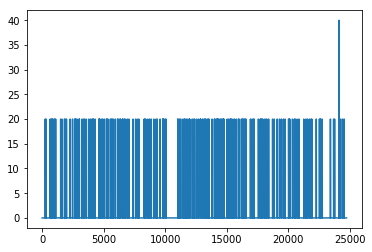

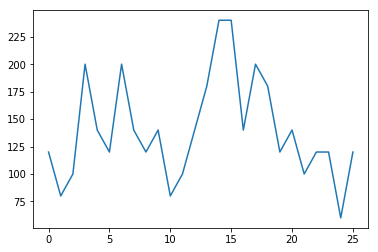

In [11]:
import matplotlib.pyplot as plt
print(np.mean(reward_lst))
plt.plot(reward_lst)
plt.show()
plt.plot(scores)

In [15]:
np.mean(scores)

140.0

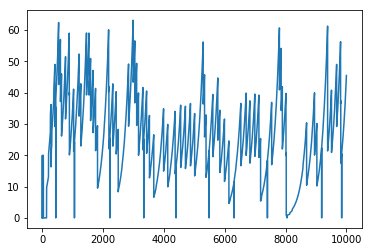

In [12]:
plt.plot(agent.r_disco)
#plt.plot(agent.d*20)

In [13]:
np.mean(reward_lst)

0.14724323449698637

In [14]:
np.mean(score)

0.0

In [ ]:
#Чтобы анализировать разрешимость задачи
def replicate_reward(sar,border=0,wanted_part=0.5):
    part = np.mean(sar[:,-1:]>border)
    if part==0:
        print('ERROR')
        return(sar)
    else:
        while part<wanted_part:
            sar=np.vstack((sar,sar[np.where(sar[:,-1:]>border)[0],:]))
            part = np.mean(sar[:,-1:]>border)
        print(part)
        return(sar)

In [ ]:
sar=make_sar_table(s_list,a_list,reward_lst)
sar=replicate_reward(sar)
X=sar[1:,:]
Y=sar[:-1,:]
Y=sar[:-1,-1:]
Y=sar[1:,-1:]
sar_width=X.shape[1]
nn = Sequential()
nn.add(Dense(200, input_dim=sar_width, activation='relu',
                kernel_initializer='he_uniform',kernel_regularizer=keras.regularizers.l2(0.01)))
nn.add(BatchNormalization())
nn.add(Dropout(0.2))
nn.add(Dense(200, activation='relu',
                kernel_initializer='he_uniform',kernel_regularizer=keras.regularizers.l2(0.01)))
nn.add(Dropout(0.2))
nn.add(BatchNormalization())
nn.add(Dense(200, activation='relu',
                kernel_initializer='he_uniform',kernel_regularizer=keras.regularizers.l2(0.01)))
nn.add(Dropout(0.2))
nn.add(BatchNormalization())
#nn.add(Dense(sar_width, activation='linear',
#                kernel_initializer='he_uniform'))
nn.add(Dense(1, activation='linear',
                kernel_initializer='he_uniform'))

nn.summary()
nn.compile(loss='mse', optimizer=Adam(lr=0.001))
l=X.shape[0]
X_train=X[:int(l/2),:]
Y_train=Y[:int(l/2),:]
X_test=X[int(l/2):,:]
Y_test=Y[int(l/2):,:]
nn.fit(X_train, Y_train, batch_size=1200,epochs=30000, verbose=1)

In [ ]:
Y_pred=np.array(nn.predict(X_test),ndmin=2)
mse = np.mean((Y_pred-Y_test)**2)
print(mse)
rmae=np.mean(np.abs(Y_pred-Y_test))/np.mean(np.abs(Y_test))
print(rmae)
rmae_diversed=np.mean(np.abs(Y_pred-Y_test),axis=0)/np.mean(np.abs(Y_test),axis=0)
print(rmae_diversed)

In [ ]:
colnumn_num=-1
plt.plot(Y_pred[:3000,colnumn_num])
plt.plot(Y_test[:3000,colnumn_num])
plt.show()

In [ ]:
#train (переобучение?)
Y_pred=np.array(nn.predict(X_train),ndmin=2)
mse = np.mean((Y_pred-Y_train)**2)
print(mse)
rmae=np.mean(np.abs(Y_pred-Y_train))/np.mean(np.abs(Y_train))
print(rmae)
rmae_diversed=np.mean(np.abs(Y_pred-Y_train),axis=0)/np.mean(np.abs(Y_train),axis=0)
print(rmae_diversed)

colnumn_num=-1
plt.plot(Y_pred[:1300,colnumn_num])
plt.plot(Y_train[:1300,colnumn_num])
plt.show()

In [ ]:
import xgboost as xgb
xgbparams = {
    'booster':'gbtree',
    'metric':'mse',
    'objective':'reg:squarederror',
    'verbosity':0,
    'max_depth': 7,
    'n_estimators': 90,
    'eta': 0.3,
    'nthreads': 2,
    'seed':0
}
nn=xgb.XGBRegressor(**xgbparams)
nn.fit(X_train[:int(l/4),:], Y_train[:int(l/4),:],
           eval_set=[(X_train[int(l/4):,:], Y_train[int(l/4):,:])],
           verbose=True)

In [11]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

/home/sd/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sd/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sd/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sd/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: Futu

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9342075230699166594
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6504904240868563997
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1726282195822852604
physical_device_desc: "device: XLA_GPU device"
]


In [15]:
tf.__version__

'2.1.0'

In [10]:
%%time
for i in range(10):
    i2v.get_vec(state,resize_type='resize')

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node model/Conv1/Conv2D (defined at <ipython-input-4-55a1e9a28c04>:33) ]] [Op:__inference_distributed_function_8866]

Function call stack:
distributed_function
